### Setting up the script functions
#### Loading packages
The majority of these packages come with most Python distributions, if you don't have any installed I recommend Anaconda to get you started. You will need to install the hyperspy package though, details on how to do that are on the webpage (http://hyperspy.org/hyperspy-doc/current/user_guide/install.html)

In [1]:
import hyperspy.api as hs
import numpy as np
from scipy import ndimage as ndi
import os
import glob

import math

These functions from matplotlib are for plotting our data, they're not absolutely necessary but are a nice touch

In [2]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import SI_LENGTH_RECIPROCAL

import matplotlib.patches as mpatches
from matplotlib import colors
from matplotlib import gridspec
%matplotlib notebook

#### Colourbars
The standard Esprit style colourmaps that go from black to a given colour (with 100% opacity) aren't in matplotlib's colourmpa library so you can either use some of their native colourmaps, 'viridis' and 'magma' are ones I'd recommend, with the rest listed here: https://matplotlib.org/tutorials/colors/colormaps.html). \\

If you want to be consistent with Esprit where you assign each element a colour this function will allow you to create your own colourmap:

In [3]:
from matplotlib.colors import ListedColormap
def create_cbar(R,G,B,A,N):
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(R[0]/N, R[1]/N, N)
    vals[:, 1] = np.linspace(G[0]/N, G[1]/N, N)
    vals[:, 2] = np.linspace(B[0]/N, B[1]/N, N)
    vals[:, 3] = np.linspace(A[0]/N, A[1]/N, N)
    return ListedColormap(vals)

In [4]:
blue=create_cbar([0,0],[0,0],[0,255],[256,256],256)
green=create_cbar([0,0],[0,255],[0,0],[256,256],256)
red=create_cbar([0,255],[0,0],[0,0],[256,256],256)

cyan=create_cbar([0,0],[0,255],[0,255],[256,256],256)
yellow=create_cbar([0,255],[0,255],[0,0],[256,256],256)
magenta=create_cbar([0,255],[0,0],[0,255],[256,256],256)

# You can create a list of these colourmaps to reference when plotting later
cbars=[yellow,magenta,blue,cyan,red,green]
clrs=['y','m','b','c','r','g']

### File types
One advantage of python is that we can batch import multiple bcfs and process them in bulk while outputting relevant data to individual folders for each or we take one single spectrum image process it step-by-step, recording data at each step. 
#### Esprit/Velox
This script will only consider processing of bcf files for the time being, though the Velox ('.emd' I think) files are extremely similar and you'd only need to make minor modifications to work with them. Bruker files can be readily imported by hyperspy to give a list consisting of ADF image and the spectrum image (Velox somewhat similar but will likely contain additional entries for any a survey image and any maps/ROIs plotted).
#### Digital Micrograph
DigitalMicrograph files are similar in that each .dm3 file (one for each of ADF, EDS, LL-EELS, CL-EELS, etc.) can be imported and processed easily enough. Files imported from dm3s into hyperspy will have less metadata than bcf though (not sure whether DM writes less, or hyperspy reads less).
#### Aztec
Aztec files cannot directly be imported for time being (apparently a convenient hyperspy-friendly format is in the works) but there is a (slightly awkward) workaround. In Aztec you can export each spectrum image within a project as in '.raw'/'.rpl' format. This gives two files, one containing the numerical data and the other containing headers which refer to the data (similar to .ser and .emi from FEI). The .rpl file can be read by hyperspy (provided corresponding .raw file is in the same directory with the same name) however it doesn't include any calibration nor metadata. To calibrate the spatial and energy axes you then need to go to Aztec to find them, then manually enter them in hyperspy's axes_manager for each file. You can export a export a summed spectra from Aztec, import it as a .emsa file alongside the .rpl file, then use it to calibrate the energy axis and give some metadata.


### Loading files
Here I'll go through batch loading of files, but with individual processing of each. Batch processing is relatively straight forward once you understand how the script works, you can just loop each function as appropriate, store the data you want to carry on and save plots where necessary.

Alongside this script there are a few sub-directories containing bcf files of FePS$_{3}$ flakes that can be used as examples in this script. Alternatively you can modify where appropriate to input your own files. 

To start we'll use a tool called glob to look through a specified directory (in this case the current directory where the .ipynb is located) and find all filenames that end in .bcf

In [5]:
fs = [f for f in glob.glob("**/*.bcf", recursive=True)]

In [6]:
fs

['Flake1\\flake1.bcf',
 'Flake2\\flake2.bcf',
 'Flake3\\flake3.bcf',
 'map4-15min-100us-180pA\\4.bcf',
 'map5-10min-100us-180pA\\5.bcf']

From here we'll take 'map4-15min-100us-180pA\\4.bcf' as an example. It's list index is 3 (python will index lists from 0)

In [7]:
i=3

This will create a save folder with a similar name within the directory of the .bcf file

In [8]:
f=fs[i]
f_name=fs[i].split(r'.')[0]

In [9]:
savefolder=f_name[:]+r'_Output'
if not os.path.exists(savefolder):
    os.makedirs(savefolder)

The file is then loaded (this could take a while for very large files)

In [10]:
s=hs.load(f)

As mentioned before, two files are imported and we can separate these into the ADF image (im) and spectrum image (si)

In [11]:
im=hs.transpose(s[0])[0]
si=s[1]

#### Processing spectrum images
#### Spatial calibration
This is simply rescaling the ADF image and spectrum image to be calibrated in nm rather than microns (optional)

In [12]:
im.axes_manager.navigation_axes[0].units,im.axes_manager.navigation_axes[0].scale='nm',(hs.transpose(s[0])[0]).axes_manager.navigation_axes[0].scale
im.axes_manager.navigation_axes[1].units,im.axes_manager.navigation_axes[1].scale='nm',(hs.transpose(s[0])[0]).axes_manager.navigation_axes[1].scale
si.axes_manager.navigation_axes[0].units,si.axes_manager.navigation_axes[0].scale='nm',s[1].axes_manager.navigation_axes[0].scale*1000
si.axes_manager.navigation_axes[1].units,si.axes_manager.navigation_axes[1].scale='nm',s[1].axes_manager.navigation_axes[1].scale*1000

#### Binning
Binning  is something that's often overlooked in Esprit but is extremely important for extracting data from your elemental/compositional maps as well as making sure elemental distributions are clearly visible. You can either spatially bin the spectrum image (binning along navigation axes) or spectrally bin the energy axis at each pixel (binning along signal axis)

Here the SI will be binned by \textit{bn} along x and y, and \textit{bs} along the energy axis. Spatial binning will improve the signal at each pixel (boosting the number of counts), improving the overall SNR but will reduce the spatial resolution of your map. Binning the energy axes will also boost counts at each pixel but at the expense of spectral resolution, meaning peaks that are close together will merge and any maps derived will have severe problems. Practically speak the energy axes from 0 to 20 keV should have at least 512 channels, if not 1024.

In [13]:
bn,bs=24,2 # here we're binning by 20 (x, y) and 3 (E)
sr=si.rebin(scale=[bn,bn,bs])
ir=im.rebin(scale=[bn,bn])

You can crop the signal axis using .isig[lim1:lim2] where lim1 and lim2 are lower and upper limits in keV respectively (make sure you use decimals, integer values will crop to the channel values rather than energy values) 

<IPython.core.display.Javascript object>


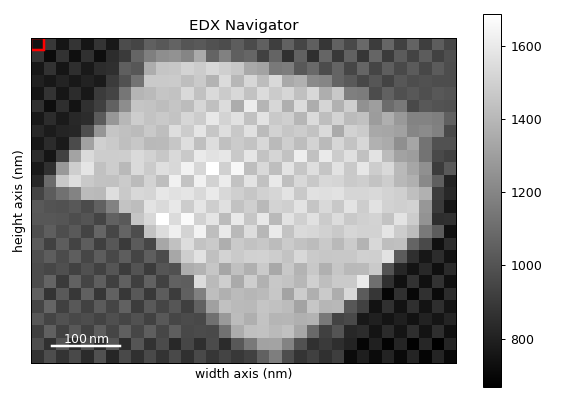

<IPython.core.display.Javascript object>


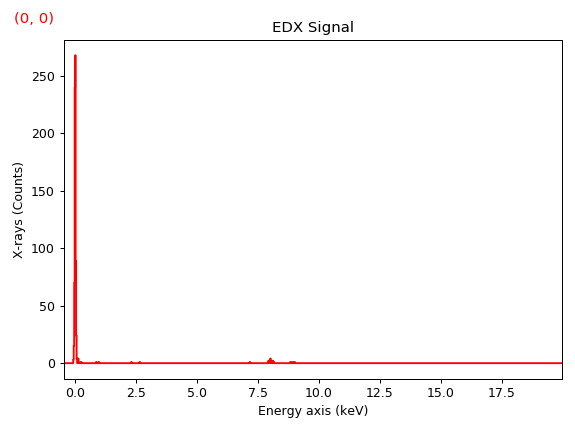

In [14]:
sr.isig[:].plot()

### Elemental analysis
#### Mapping x-ray counts
If you added any elements to the spectrum image while acquiring data in Esprit (or Velox) they will be pre-loaded here, you can check in the SI metadata. Otherwise, or to add new elements/X-ray lines, you can set them based on a list of elements or X-ray counts (see below).

In [15]:
sr.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 45.0
│       │       ├── detector_type = SuperX
│       │       ├── elevation_angle = 18.0
│       │       ├── energy_resolution_MnKa = 130.0
│       │       └── real_time = 515322.432
│       ├── Stage
│       │   └── tilt_alpha = 0.0
│       ├── beam_energy = 200
│       └── magnification = 115000
├── General
│   ├── date = 2019-10-12
│   ├── original_filename = 4.bcf
│   ├── time = 10:09:21
│   └── title = EDX
├── Sample
│   ├── elements = ['Fe', 'O', 'P', 'S']
│   ├── name = Map data
│   └── xray_lines = ['Fe_Ka', 'O_Ka', 'P_Ka', 'S_Ka']
└── Signal
    ├── binned = True
    ├── quantity = X-rays (Counts)
    └── signal_type = EDS_TEM

Hyperspy has a library of elemental information where you can look up energies of X-ray lines and atomic binding energies

In [16]:
hs.material.elements.Cu

├── Atomic_properties
│   ├── Binding_energies
│   │   ├── L1
│   │   │   ├── factor = 1
│   │   │   ├── filename = Cu.L1
│   │   │   ├── onset_energy (eV) = 1096.0
│   │   │   └── relevance = Minor
│   │   ├── L2
│   │   │   ├── factor = 0.5
│   │   │   ├── filename = Cu.L3
│   │   │   ├── onset_energy (eV) = 951.0
│   │   │   └── relevance = Major
│   │   ├── L3
│   │   │   ├── factor = 1
│   │   │   ├── filename = Cu.L3
│   │   │   ├── onset_energy (eV) = 931.0
│   │   │   └── relevance = Major
│   │   ├── M2
│   │   │   ├── factor = 0.5
│   │   │   ├── filename = Cu.M3
│   │   │   ├── onset_energy (eV) = 74.0
│   │   │   └── relevance = Major
│   │   └── M3
│   │       ├── factor = 1
│   │       ├── filename = Cu.M3
│   │       ├── onset_energy (eV) = 74.0
│   │       └── relevance = Major
│   └── Xray_lines
│       ├── Ka
│       │   ├── energy (keV) = 8.0478
│       │   └── weight = 1.0
│       ├── Kb
│       │   ├── energy (keV) = 8.9053
│       │   └── weight = 0.13157
│       

In [17]:
sr.set_elements(['C','Cu','Fe','O','P','S']) # Try to keep lists of elements and X-ray lines alphabetical as their order is important later on!
sr.set_lines(['C_Ka','Cu_Ka','Cu_La','Fe_Ka','Fe_La','O_Ka','P_Ka','S_Ka']) 
# Here we need to include the Cu and Fe L edges for accurate background subtraction later on 
# But we don't need to plot their intensities so they are exclude from the 'get_lines_intensity' function in the next cell

First of all we'll map the X-rays by using the default peak fitting built-in to hyperspy. We do this using the get_lines_intensity feature, which can be used on either a sum spectra (spectra from every pixel summed into one overall spectrum) or on a spectrum image (giving a map of X-ray line intensities). 

#### Sum Spectrum
In this cell the line intensities are measured from the sum spectrum for the lines within the get_lines_intensity function. We crop the energy axis to 0.1-10.0 keV for visual clarity and print the summed intensity value for each element.

<IPython.core.display.Javascript object>


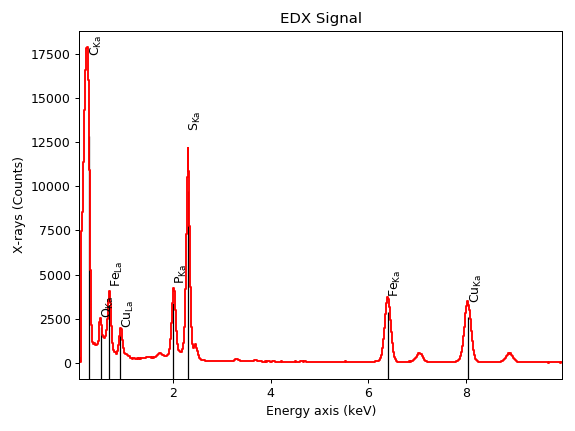

C | 67962
Cu | 27911
Fe | 27106
O | 11467
P | 20911
S | 60225


In [18]:
sr.isig[0.1:10.0].sum().plot(True)
ints_sum=sr.sum().get_lines_intensity(['C_Ka','Cu_Ka','Fe_Ka','O_Ka','P_Ka','S_Ka'])
for n in range(len(ints_sum)):
    print(str(ints_sum[n].metadata.Sample.elements)[2:-2],'|',int(ints_sum[n].data))

#### Elemental Mapping

In [19]:
ints=sr.get_lines_intensity(['C_Ka','Cu_Ka','Fe_Ka','O_Ka','P_Ka','S_Ka'])

If the get_lines_intensity function is applied to a full spectrum image, it will output a list of elemental maps, one for each of the input X-ray lines (in this case ['C_Ka','Cu_Ka','Fe_Ka','O_Ka','P_Ka','S_Ka']). The next cell will plot each elemental map individually and save them as both .png and .svg files to the specified save folder.

The scalebar will be automatically read from the (rebinned) SI axes_manager and the titles from the metadata. 

#### Saving maps individually

<IPython.core.display.Javascript object>


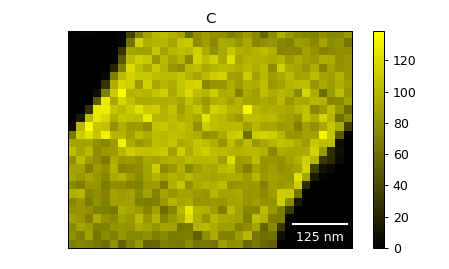

<IPython.core.display.Javascript object>


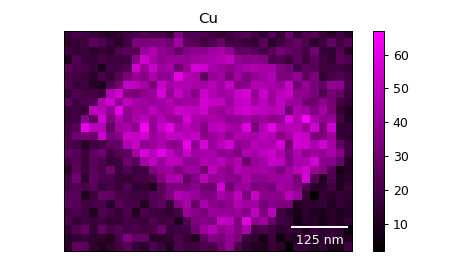

<IPython.core.display.Javascript object>


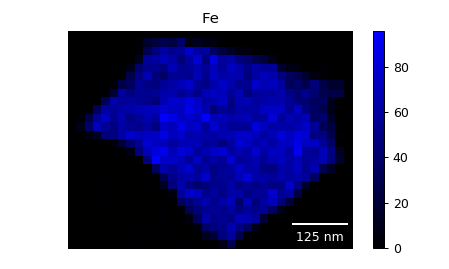

<IPython.core.display.Javascript object>


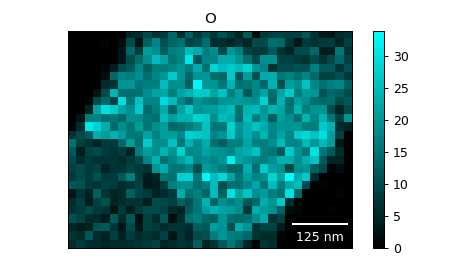

<IPython.core.display.Javascript object>


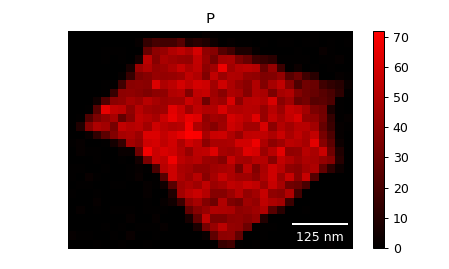

<IPython.core.display.Javascript object>


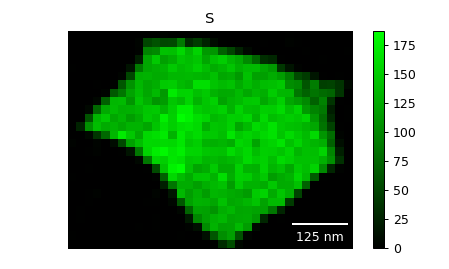

In [20]:
for n in range(len(ints)): 
    fig, axs = plt.subplots(nrows=1,ncols=1)
    fig.set_size_inches(5.0,3.0)
    axs.set_title(str(ints[n].metadata.Sample.elements)[2:-2])
    axs.set_aspect('equal')
    axs.set_xticks([])
    axs.set_yticks([])
    plt.gca().add_artist(ScaleBar(sr.axes_manager.navigation_axes[0].scale,units='nm',frameon=False,color='white',location='lower right'))
    plt.colorbar(axs.imshow(ints[n],cmap=cbars[n],interpolation=None),ax=axs) # To interpolate image set interpolation equal to any of 'nearest', bicubic', 'bilinear', etc,
    # If you would rather use a matplotlib colourmap you need to set cmap='viridis' (or whichever you choose)
        
    plt.tight_layout()
    plt.savefig(savefolder+'/'+str(ints[n].metadata.Sample.elements)[2:-2]+'.png')
    plt.savefig(savefolder+'/'+str(ints[n].metadata.Sample.elements)[2:-2]+'.svg') 
    # Scalable vector graphics (svg) files are the best way to export images as you will be able to 
    # rescale features, modify text, add/remove titles/scalebars/colourbars, recolour channels, etc.
    # They can be opened in InkScape (or Adobe Illustrator)
    # It's also useful to save them as png so they can be previewed quickly

#### Multi-panel figures
In a lot of cases it's easier to just produce a single multi-panel figure that you can edit later. Depending on the number of elements you're interested in, your plots will need adjusting (number of columns, rows, sizes). 

<IPython.core.display.Javascript object>


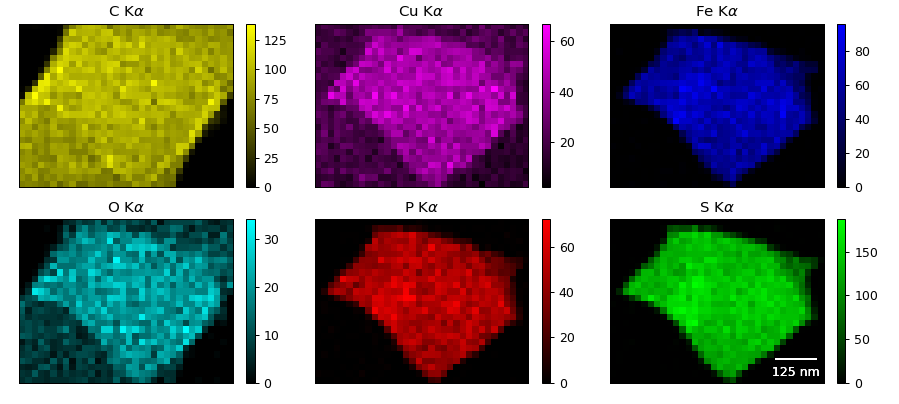

In [21]:
nr,nc=2,3
fig, axs = plt.subplots(nrows=nr,ncols=nc)
fig.set_size_inches(10.0, 4.5) # change the size of the plot
for n in np.arange(0,nc,1): 

    #axs[0][n].imshow(ints[n],cmap=cbars[n])
    axs[0][n].set_title(str(ints[n].metadata.Sample.elements)[2:-2]+r' K$\alpha$')
    axs[0][n].set_aspect('equal')
    axs[0][n].set_xticks([])
    axs[0][n].set_yticks([])
    plt.gca().add_artist(ScaleBar(sr.axes_manager.navigation_axes[0].scale,units='nm',frameon=False,color='white',location='lower right'))
    plt.colorbar(axs[0][n].imshow(ints[n],cmap=cbars[n]),ax=axs[0][n])
    
    axs[1][n].imshow(ints[n+3],cmap=cbars[n])
    axs[1][n].set_title(str(ints[n+nc].metadata.Sample.elements)[2:-2]+r' K$\alpha$')
    axs[1][n].set_xticks([])
    axs[1][n].set_yticks([])
    plt.colorbar(axs[1][n].imshow(ints[n+3],cmap=cbars[n+nc]),ax=axs[1][n])
    
plt.tight_layout()
plt.savefig(savefolder+'/01_eds_counts.png')
plt.savefig(savefolder+'/01_eds_counts.svg')

#### Background subtraction
Removal of background (bremmstrahlung) is mandatory before performing quantification on EDS spectra (and spectrum images). The windows method is fairly straightforward to implement so we'll use it here. The idea is to measure counts either side of each X-ray lines (these measured areas are the 'windows') and take the average of both as being the background height beneath X-ray peak. This can then be subtracted from X-ray counts measured using 'get_lines_intensity'.

An alternative method is to fit a model based on Gaussians (for X-ray peaks) and a PowerLaw background to the spectrum. X-ray intensities are then measured from the model components rather than the raw spectrum. I will get around to including it in a future version of this notebook but for now we'll stick with the windows method.

You need to be careful choosing the width of you background windows (windows_width) and where they are relative to the X-ray lines (line_width). As you we have input all X-ray lines present (including the Fe and Cu L lines) into the spectrum image metadata, hyperspy's estimate_background_windows function knows not to place windows where X-ray lines are. If you haven't accounted for all peaks present your background subtraction will be faulty and you may end up with a lot of negative X-ray counts.

<IPython.core.display.Javascript object>


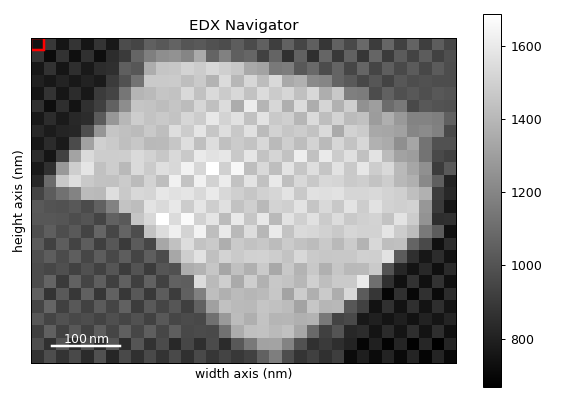

<IPython.core.display.Javascript object>


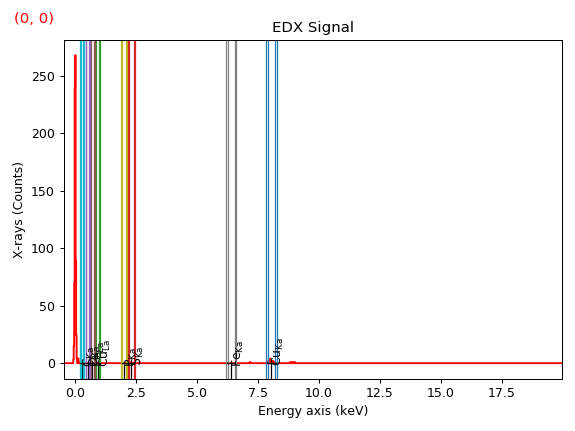

In [22]:
bw=sr.estimate_background_windows(line_width=[1.0,1.0],windows_width=0.5)
sr.isig[:].plot(True,background_windows=bw)

In [23]:
ints_b=sr.get_lines_intensity(['C_Ka','Cu_Ka','Fe_Ka','O_Ka','P_Ka','S_Ka'],background_windows=bw)

In this case our subtraction isn't 100% perfect in that a few pixels show -1 oxygen counts as there is very little O present. As there are only a few small negative values we can just set them equal to 0 in the cell below

In [24]:
for n in range(len(ints_b)):
    ints_b[n].data[ints_b[n].data<0]=0

<IPython.core.display.Javascript object>


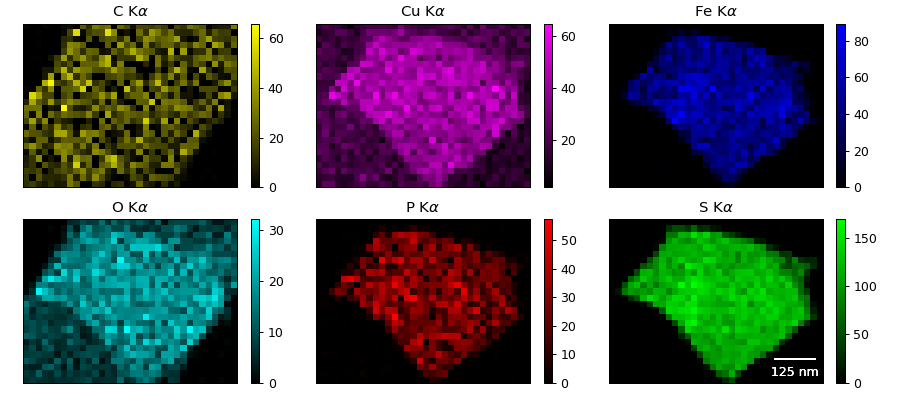

In [25]:
fig, axs = plt.subplots(nrows=nr,ncols=nc)
fig.set_size_inches(10.0, 4.5) # change the size of the plot
for n in np.arange(0,nc,1): 

    #axs[0][n].imshow(ints[n],cmap=cbars[n])
    axs[0][n].set_title(str(ints[n].metadata.Sample.elements)[2:-2]+r' K$\alpha$')
    axs[0][n].set_aspect('equal')
    axs[0][n].set_xticks([])
    axs[0][n].set_yticks([])
    plt.gca().add_artist(ScaleBar(sr.axes_manager.navigation_axes[0].scale,units='nm',frameon=False,color='white',location='lower right'))
    plt.colorbar(axs[0][n].imshow(ints_b[n],cmap=cbars[n]),ax=axs[0][n])
    
    #axs[1][n].imshow(ints[n+3],cmap=cbars[n])
    axs[1][n].set_title(str(ints[n+nc].metadata.Sample.elements)[2:-2]+r' K$\alpha$')
    axs[1][n].set_xticks([])
    axs[1][n].set_yticks([])
    plt.colorbar(axs[1][n].imshow(ints_b[n+3],cmap=cbars[n+nc]),ax=axs[1][n])
    
plt.tight_layout()
plt.savefig(savefolder+'/02_eds_counts_bkg.png')
plt.savefig(savefolder+'/02_eds_counts_bkg.svg')

### Quantification
We're going to use the Cliff-Lorimer method, where k-factors are used to calculate atomic (or weight) percentages. K-factors for each element are calculated by comparison to a common k-factor, in this case we're going to use theoretical k-factors from the Titan (calculated by Bruker) that are evaluated relative to Si. I've got a list of these I'll put in the group Dropbox for you to check.

K-factors are loaded as a list in the same order as your intensities were measured. Similar to get_lines_intensity, the quantification function will produced either singular values for each element if a sum spectrum is used, or compositional maps if a spectrum image is input.

In [26]:
kfacs=[2.672,1.823,1.471,1.172,1.090,1.040]
comp=sr.quantification(intensities=ints_b,method='CL',factors=kfacs,composition_units='atomic')
# Set composition_units='weight' if you want results in wt%

C:\ProgramData\Anaconda3\lib\site-packages\hyperspy\misc\eds\utils.py:447: RuntimeWarning: divide by zero encountered in double_scalars
  / intensities[i] / kfactors[i]


<IPython.core.display.Javascript object>


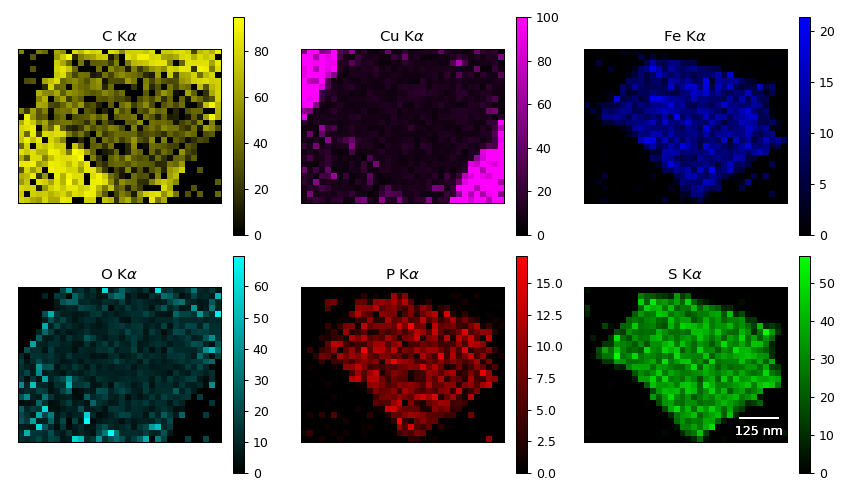

In [27]:
fig, axs = plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(9.5, 5.5)

for n in np.arange(0,3,1):

    #axs[0][n].imshow(ints[n],cmap=cbars[n])
    axs[0][n].set_title(str(comp[n].metadata.Sample.elements)[2:-2]+r' K$\alpha$')
    axs[0][n].set_aspect('equal')
    axs[0][n].set_xticks([])
    axs[0][n].set_yticks([])
    plt.gca().add_artist(ScaleBar(sr.axes_manager.navigation_axes[0].scale,units='nm',frameon=False,color='white',location='lower right'))
    plt.colorbar(axs[0][n].imshow(comp[n],cmap=cbars[n],vmin=0),ax=axs[0][n])
    
    #axs[1][n].imshow(ints[n+3],cmap=cbars[n])
    axs[1][n].set_title(str(comp[n+3].metadata.Sample.elements)[2:-2]+r' K$\alpha$')
    axs[1][n].set_xticks([])
    axs[1][n].set_yticks([])
    plt.colorbar(axs[1][n].imshow(comp[n+3],cmap=cbars[n+3],vmin=0),ax=axs[1][n])
    
plt.tight_layout()
plt.savefig(savefolder+r'\03_eds_comps.png')
plt.savefig(savefolder+r'\03_eds_comps.svg')

### Extra features
The next section is just a few extra features hyperspy is capable of that aren't as easily implemented in Esprit (or Velox). They're just here to serve as an example, feel free to modify and develop them as much as you like. Over the next few weeks I'll be putting together notebooks that expand on the material covered here and that will look at more advanced capabilities.

#### Masking
It's clear from the maps that we have a well-defined flake that consists of Fe, P and S. In addition we can also see the carbon film and some oxygen dispersed over the specimen, as well as spurious Cu counts from the copper grid bars. We are only really concerned with Fe, P, S and O (these flakes tend to degrade in air, causing S to be ejected as the flake surface/edges oxidise). As such, we'll spatial mask all the elemental signals so that only X-rays emitted from the flake area are considered.

This could also be done based on X-ray counts before quantification with similar effects.

<IPython.core.display.Javascript object>


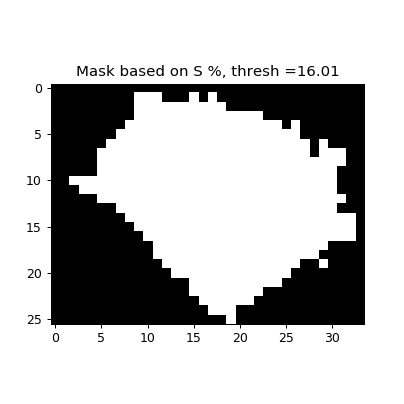

In [28]:
thresh=np.median(comp[5].data) # This threshold determines which pixels are included in the mask,
mask=(comp[5].data>thresh)     # here I've set it to the median of the S counts but you can put any number in
mask=ndi.morphology.binary_fill_holes(mask).astype(int)
plt.figure(figsize=(4.5,4.5))
plt.imshow(mask)
title=plt.title('Mask based on '+str(comp[5].metadata.Sample.elements)[2:-2]+' %, thresh ='+str(np.round(thresh,2)))

We then replot the compositional maps (this could also be done for the X-ray count maps) multiplied by the binary mask. Everywhere the mask is 0, the corresponding pixel in the compositional map is also set to zero

<IPython.core.display.Javascript object>


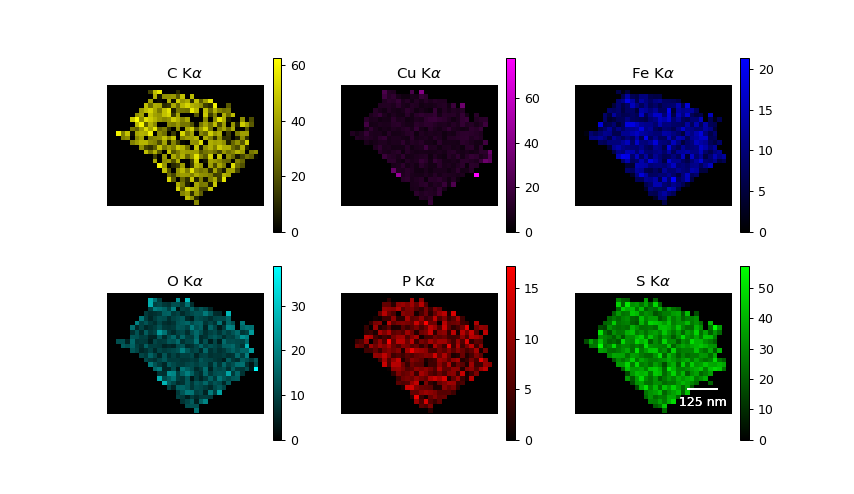

In [29]:
fig, axs = plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(9.5, 5.5)

for n in np.arange(0,3,1):

    #axs[0][n].imshow(ints[n],cmap=cbars[n])
    axs[0][n].set_title(str(comp[n].metadata.Sample.elements)[2:-2]+r' K$\alpha$')
    axs[0][n].set_aspect('equal')
    axs[0][n].set_xticks([])
    axs[0][n].set_yticks([])
    plt.gca().add_artist(ScaleBar(sr.axes_manager.navigation_axes[0].scale,units='nm',frameon=False,color='white',location='lower right'))
    plt.colorbar(axs[0][n].imshow(comp[n]*mask,cmap=cbars[n],vmin=0),ax=axs[0][n])
    
    #axs[1][n].imshow(ints[n+3],cmap=cbars[n])
    axs[1][n].set_title(str(comp[n+3].metadata.Sample.elements)[2:-2]+r' K$\alpha$')
    axs[1][n].set_xticks([])
    axs[1][n].set_yticks([])
    plt.colorbar(axs[1][n].imshow(comp[n+3]*mask,cmap=cbars[n+3],vmin=0),ax=axs[1][n])

plt.savefig(savefolder+r'\04_eds_comps_masked.png')
plt.savefig(savefolder+r'\04_eds_comps_masked.svg')

#### Line profiles

In [30]:
def length(i,o):
    l=math.sqrt((i[0]-o[0])**2+(i[1]-o[1])**2)
    return l

def t_measure(im,i,o):
    num = np.round(length([i[1],i[0]],[o[1],o[0]]),2)
    xl, yl = np.linspace(i[1],o[1],num),np.linspace(i[0],o[0],num)
    z = ndi.map_coordinates(np.transpose(im), np.vstack((xl,yl)))
    return z

To extract a line profile mirrored across each elemental map, we need to input the beginning and end coordinates of the line profile (i and o respectively). These are then plotted as red squares on the ADF image with a dashed line showing the profile length in the figure's left panel. You can adjust i and o and make sure they're in the right locations based on the marked image.

The right panel then plots the atomic (or weight) percent at each distance along the profile, with horizontal dotted lines showing the median value for each element (which is listed numerically in the legend normalised to Fe composition). 

<IPython.core.display.Javascript object>


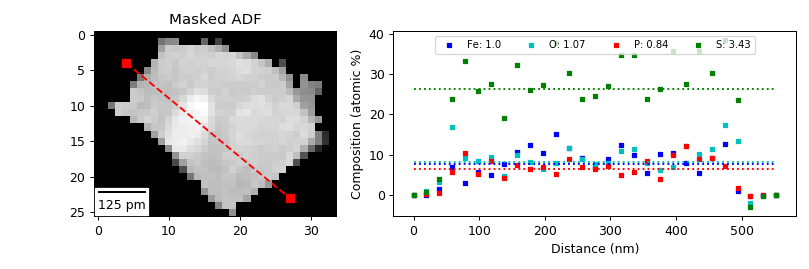

In [34]:
i=(4,4)#(15,24)
o=(27,23)#(15,5)

plt.figure(figsize=(9.0,3.0),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(ir*mask)
plt.title('Masked ADF')
scaleb=ScaleBar(dx=ir.axes_manager.navigation_axes[0].scale,units='nm',dimension='si-length',location='lower left')
plt.gca().add_artist(scaleb)
plt.scatter([i[0],o[0]],[i[1],o[1]],marker='s',color='r')
plt.plot([i[0],o[0]],[i[1],o[1]],color='r',linestyle='dashed')
#plt.text(x=ir.data.shape[1]*0.87,y=ir.data.shape[0]*0.05,s='DF-STEM',color='white',weight='bold',size=11)

plt.subplot(1,2,2)
for n in np.arange(2,len(comp),1):
    distances=np.linspace(0,length(i,o)*sr.axes_manager.navigation_axes[0].scale,len(t_measure(comp[n],i,o)))
    plt.scatter(distances,t_measure(comp[n]*mask,i,o),color=clrs[n],marker='s',s=8)
    plt.hlines(y=np.median(t_measure(comp[n]*mask,i,o)),xmin=distances[0],xmax=distances[-1],color=clrs[n],linestyle='dotted',label='_nolegend_')
    plt.ylabel('Composition (atomic %)')
    plt.xlabel('Distance (nm)')
    
avs=[]
for n in np.arange(2,len(comp),1):
    avs.append(str(comp[n].metadata.Sample.elements)[2:-2]+': '+str(np.round(np.median(t_measure(comp[n]*mask,i,o)/np.median(t_measure(comp[2]*mask,i,o))),2)))
plt.legend(avs,loc='upper center',ncol=4,fontsize=8)

plt.savefig(savefolder+r'\05_lp.png')
plt.savefig(savefolder+r'\05_lp.svg')

#### Compositional statistics from the spectrum image
The line profile above shows that the compositions of each element varies quite a bit over distances. To visualise the spread of these values we can produce histograms based all pixels within the spectrum image. To do this we first convert the hyperspy objects into flattened arrays (1D arrays where rather than the pixels being arranged in two dimensions, as in a spectrum image, they are listed along one dimension). 

We then set all 0 values (from the unmasked areas) to 'NaN' so they aren't included in the plots

In [32]:
hcomp=[]
for n in range(2,len(comp)):
    s=(comp[n].data*mask).flatten()
    s[s==0]='NaN'
    hcomp.append(s)

Finally we can plot the histograms. In this case we've just plotted Fe, P and S, hence we run the for loop over indices [0,2,3]. If you want to include O just add 1 to the list.

<IPython.core.display.Javascript object>


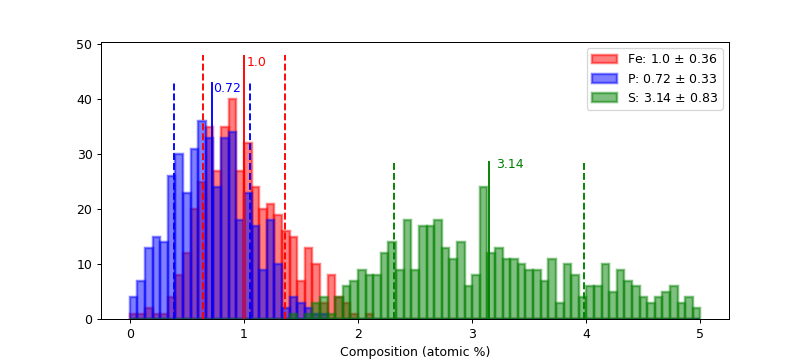

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [33]:
lbls=['Fe','O','P','S',]
hclrs=['red','cyan','blue','green']

plt.figure(figsize=(9.0,4.0))
for n in [0,2,3]:
    mean=np.nanmean(hcomp[n]/np.nanmean(hcomp[0]))
    std=np.nanstd(hcomp[n]/np.nanmean(hcomp[0]))
    h=plt.hist(hcomp[n]/np.nanmean(hcomp[0]),bins=75,range=(0.0,5.0),alpha=0.5,linewidth=2.0,
               color=hclrs[n],edgecolor=hclrs[n],label=lbls[n]+': '+str(np.round(mean,2))+r' $\pm$ '+str(np.round(std,2)))
    
    plt.vlines([mean],ymin=0,ymax=np.max(h[0])*1.2,colors=hclrs[n],label='_0')
    plt.vlines([mean+std],ymin=0,ymax=np.max(h[0])*1.2,linestyles=['dashed'],colors=hclrs[n],label='_0')
    plt.vlines([mean-std],ymin=0,ymax=np.max(h[0])*1.2,linestyles=['dashed'],colors=hclrs[n],label='_0')
    plt.text(x=mean*1.02,y=np.max(h[0])*1.15,s=str(np.round(mean,2)),color=hclrs[n])

    plt.legend()
plt.xlabel('Composition (atomic %)')

plt.savefig(savefolder+r'\06_histogram.png')
plt.savefig(savefolder+r'\06_histogram.svg')